In [116]:
from websockets.sync.client import connect
import json
import pandas as pd

In this example we use the websockets library (https://websockets.readthedocs.io/en/stable/)

This is a super simple way to receive the websocket data, but feel free to use other methods

In [117]:
data = []

def receive_data():
    max_msg = 100 # Feel free to change this or just let it loop forever. Maybe best to keep it low while testing...
    with connect("ws://192.87.172.71:1338") as websocket:
        count = 0
        while count < max_msg:
            msg = websocket.recv()
            try:
                msg = json.loads(msg)
                #handle_message(msg) # Call function to do the actual data handling
            except json.JSONDecodeError:
                print("Failed to decode json, assuming next packet will be ok...")
                pass
            except Exception as e:
                # Assume something went wrong and stop receiving
                print("Something went horribly wrong!")
                print("Error:", e)
                break
            
            count += 1
            data.append(msg)
        print("Received %d messages!" % count)


# 'Packet' format
The websocket will give you one entry per packet that was received on a receiver.

The packet can have the following fields:

- `address`: The address of the airplane that transmitted this message; you can use the `address` field to match different messages for the same aircraft,
- `altitude`: The altitude (in feet [https://en.wikipedia.org/wiki/Foot_(unit)]) of the airplane,
- `latitude`: The latitude of the airplane,
- `longitude`: The longitude of the airplane,
- `speed`: The speed (in knots [https://en.wikipedia.org/wiki/Knot_(unit)]) of the airplane,
- `heading`: The heading (in degrees) of the airplane,
- `callsign`: The callsign of the airplane
- `timestamp`: The time at which the receiver received the message. Note that this will not be exactly the same on both receivers due to processing delays and the clocks not being exactly in sync!
- `rssi`: The received signal strength indication of the message as determined by the receiver,
- `receiver`: The name of the receiver that received this message (either 'zi-5067' or 'zi-5110')

Note that due to there being two receivers this also means that some packets will be received twice, once on each receiver! You can detect this by noticing that some of the fields will be identical. Only the `timestamp`, `rssi` and `receiver` fields will be different.

There are 4 different 'types' of messages you will need to handle:
- The 'location' message: Has the `altitude`, `latitude` and `longitude` information,
- The 'altitude' message: This only has the `altitude` field,
- The 'speed' message: Has the `speed` and `heading` information,
- The 'callsign' message: Has the `callsign` information.

In [118]:
def handle_message(msg):
    #print(msg)
    if 'altitude' in msg: # check if this is one of the two types with altitude info
        if msg['altitude'] * 0.3048 >= 10000:
            print("Plane {} is at 10km or higher!".format(msg['address']))

In [119]:
receive_data()

Received 100 messages!


In [120]:
df = pd.DataFrame(data)
df = df.dropna(subset = ['altitude', 'latitude', 'longitude'])

In [121]:
df_zi_5067 = df[df['receiver'] == 'zi-5067']
df_zi_5110 = df[df['receiver'] == 'zi-5110']

In [123]:
import numpy as np

#Calculate the distance bewteen plane and receiver
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers

    lat1 = np.radians(lat1) #plane latitude
    lon1 = np.radians(lon1) #plane longitude
    lat2 = np.radians(lat2) #receiver latitude
    lon2 = np.radians(lon2) #receiver longitude

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

#The location of zilverling = (52.239, 6.858)
receiver_lat = 52.239
receiver_lon = 6.858

#Add column 'distance' with a corresponding value
df.loc[:,'distance'] = haversine(df['latitude'], df['longitude'], receiver_lat, receiver_lon)
df_zi_5067.loc[:,'distance'] = haversine(df_zi_5067['latitude'], df_zi_5067['longitude'], receiver_lat, receiver_lon)
df_zi_5110.loc[:,'distance'] = haversine(df_zi_5110['latitude'], df_zi_5110['longitude'], receiver_lat, receiver_lon)

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_check(df, col):
    corr = df[col].corr(df['rssi'])  # Default is Pearson
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=col, y='rssi', hue='rssi', palette='RdYlGn')
    plt.title(f'Correlation = {corr:.2f}')
    plt.xlabel('{}'.format(col))
    plt.ylabel('Signal Strength')
    plt.grid(True)
    plt.show()

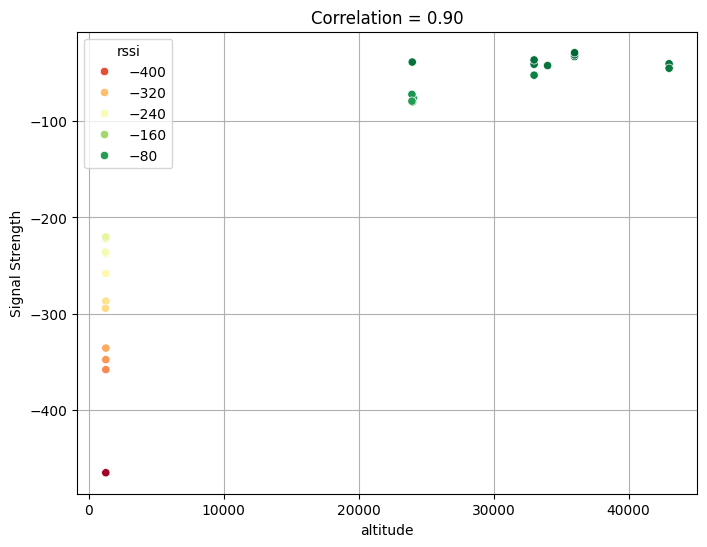

In [125]:
correlation_check(df_zi_5110, 'altitude')

In [126]:
df_dis = df.sort_values(by ="distance", ascending=False)
df_signal = df.sort_values(by="rssi", ascending=False)
df_dis.to_csv('planes_sorted_by_distance.csv') 
df_dis.to_csv('planes_sorted_by_rssi.csv') 

df_zi_5067_dis = df_zi_5067.sort_values(by="distance", ascending=False)
df_zi_5067_signal = df_zi_5067.sort_values(by="rssi", ascending=False)
df_zi_5067_dis.to_csv('zi-5067_sorted_by_distance.csv') 
df_zi_5067_signal.to_csv('zi-5067_sorted_by_rssi.csv') 

df_zi_5110_dis = df_zi_5110.sort_values(by="distance", ascending=False)
df_zi_5110_signal = df_zi_5110.sort_values(by="rssi", ascending=False)
df_zi_5110_dis.to_csv('zi-5110_sorted_by_distance.csv') 
df_zi_5110_signal.to_csv('zi-5110_sorted_by_rssi.csv') 


In [127]:
pip install folium


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: /usr/local/bin/python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [128]:
import folium
import folium.plugins as plugins

m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=8)

# Add airplane markers

def altitude_color(altitude):
    if altitude > 40000:
        return 'white'
    elif altitude > 30000:
        return 'lightblue'
    elif altitude > 20000:
        return 'blue'
    elif altitude > 10000:
        return 'darkblue'

def signal_color(signal):
    if signal > -60:
        return 'darkgreen'
    elif signal > -80:
        return 'green' 
    elif signal > -100:
        return 'orange' 
    elif signal > -120:
        return 'red'  
    else: 
        return 'darkred'

for _, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Plane{row['address']},  {row['altitude']} fts",
        icon = plugins.BeautifyIcon(
            icon = 'plane',
            icon_shape = None,
            border_width= 0,
            text_color = altitude_color(row['altitude']),
            background_color = signal_color(row['rssi'])
            )
        ).add_to(m)

folium.Marker(
        location=[52.23923592912191, 6.857271194458009],
        popup=f"receiver zi-5067",
        icon = folium.Icon(color='black', icon_color = 'white', icon ='satellite-dish', prefix = 'fa')
    ).add_to(m)
folium.Marker(
        location=[52.23895670441498, 6.85721755027771],
        popup=f"receiver zi-5067",
        icon = folium.Icon(color='black', icon_color = 'white', icon ='satellite-dish', prefix = 'fa')
    ).add_to(m)

m.save("airplanes_map.html")  # or just `m` in Jupyter Notebook to display

In [129]:
m